# PG-SCOTT result exploration

Scores generated in `find_genes_peaks.ipynb`. This notebook will serve to examine interesting peak-gene pairs based on the generated scores, and determine whether conclusions about statistical significance can be drawn from a bootstrapped approach.

In [2]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import anndata as ad

In [3]:
# load data
sensitivity_df = pd.read_csv('./data/pg_pairs_sensitivity.csv', index_col=[0, 1], header=[0, 1])
specificity_df = pd.read_csv('./data/pg_pairs_specificity.csv', index_col=[0, 1], header=[0, 1])
universality_df = pd.read_csv('./data/pg_pairs_universality.csv', index_col=[0, 1])
rna_adata = ad.read_h5ad('./data/rna.h5ad')
atac_adata = ad.read_h5ad('./data/atac.h5ad')

### View Distributions

Start by looking at the distributions associated with different scores, and how they relate to the input data (average RNA and ATAC across replicates)

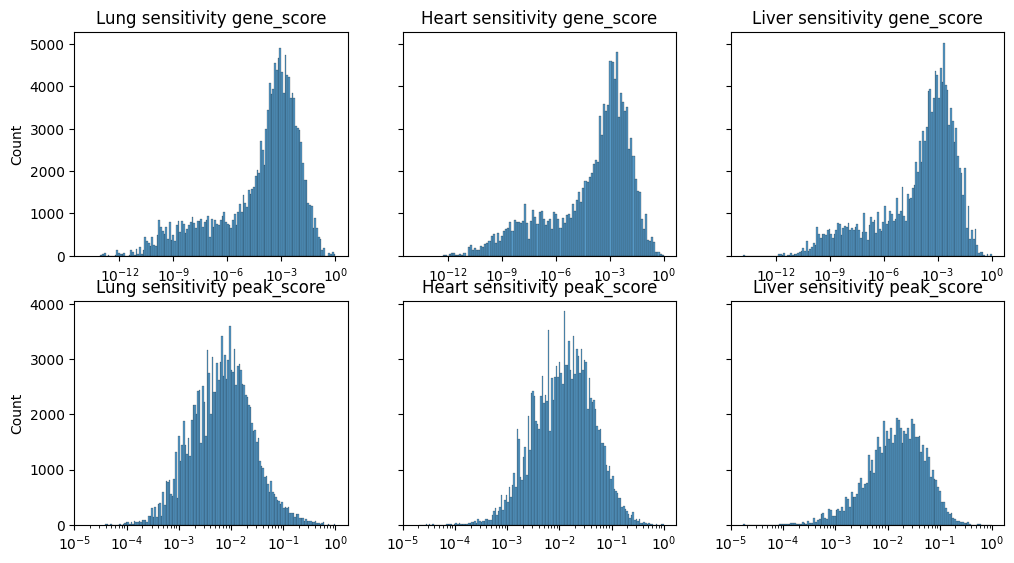

In [4]:
fig, axs = plt.subplots(2, 3, figsize=(12, 6.4), sharey='row', sharex='row')
for (col, ax) in zip(sensitivity_df.columns, axs.flatten(order='F')):
  sns.histplot(sensitivity_df[col], log_scale=(True, False), ax=ax)
  ax.set_xlabel('')
  ax.set_title(f'{col[0]} sensitivity {col[1]}')

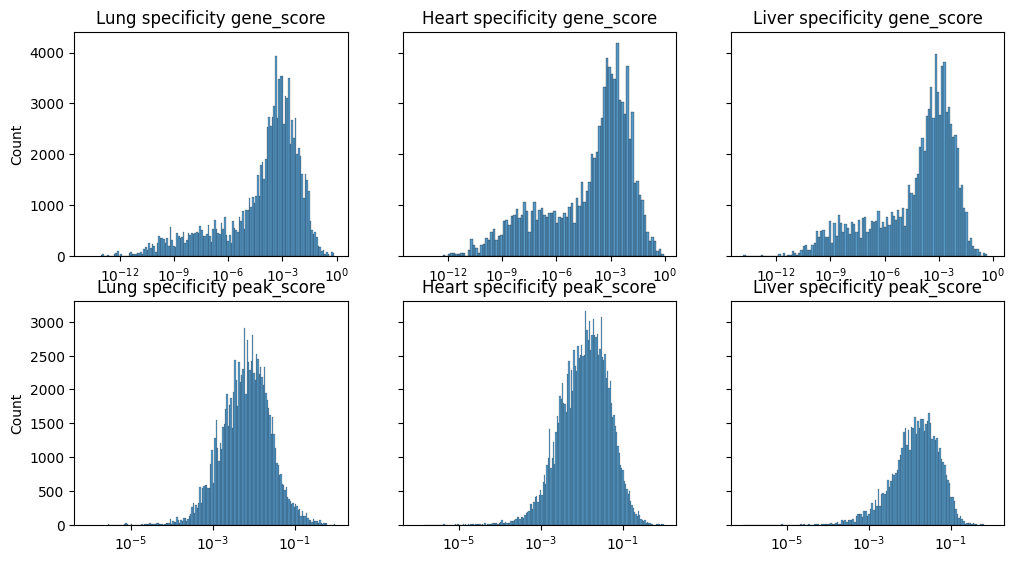

In [5]:
fig, axs = plt.subplots(2, 3, figsize=(12, 6.4), sharey='row', sharex='row')
for (col, ax) in zip(specificity_df.columns, axs.flatten(order='F')):
  sns.histplot(specificity_df[col], log_scale=(True, False), ax=ax)
  ax.set_xlabel('')
  ax.set_title(f'{col[0]} specificity {col[1]}')

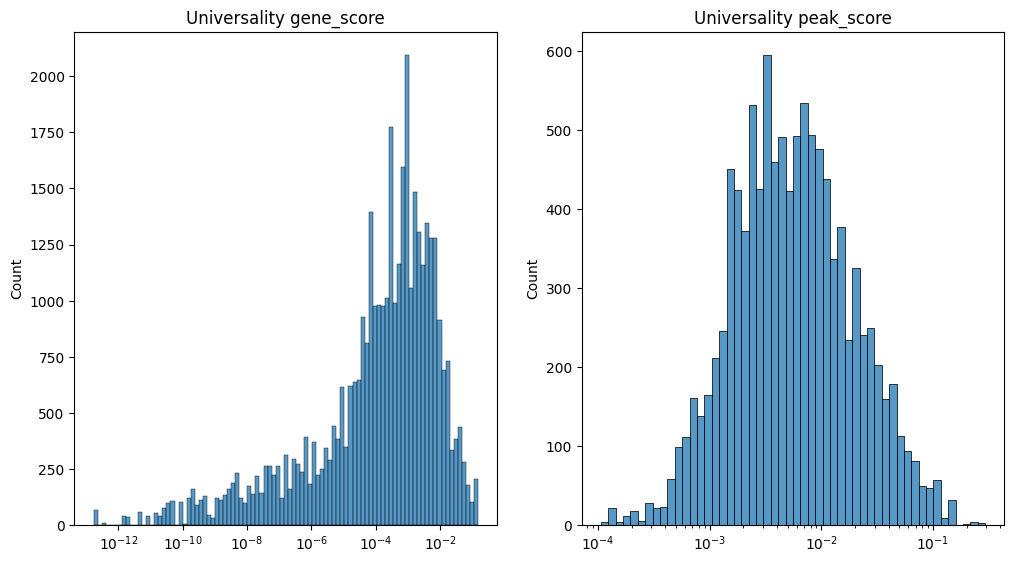

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6.4))
for (col, ax) in zip(universality_df.columns, axs.flatten(order='F')):
  sns.histplot(universality_df[col], log_scale=(True, False), ax=ax)
  ax.set_xlabel('')
  ax.set_title(f'Universality {col}')

In [7]:
def collapse_transcripts(adata: ad.AnnData, layer: str = None) -> pd.DataFrame:
  layer_df = adata.to_df(layer = layer).T
  layer_df['gene'] = adata.var['gene']
  return layer_df.groupby('gene', observed = False).aggregate('sum')  # Sum across gene variants

In [8]:
rna_raw_df = collapse_transcripts(rna_adata)

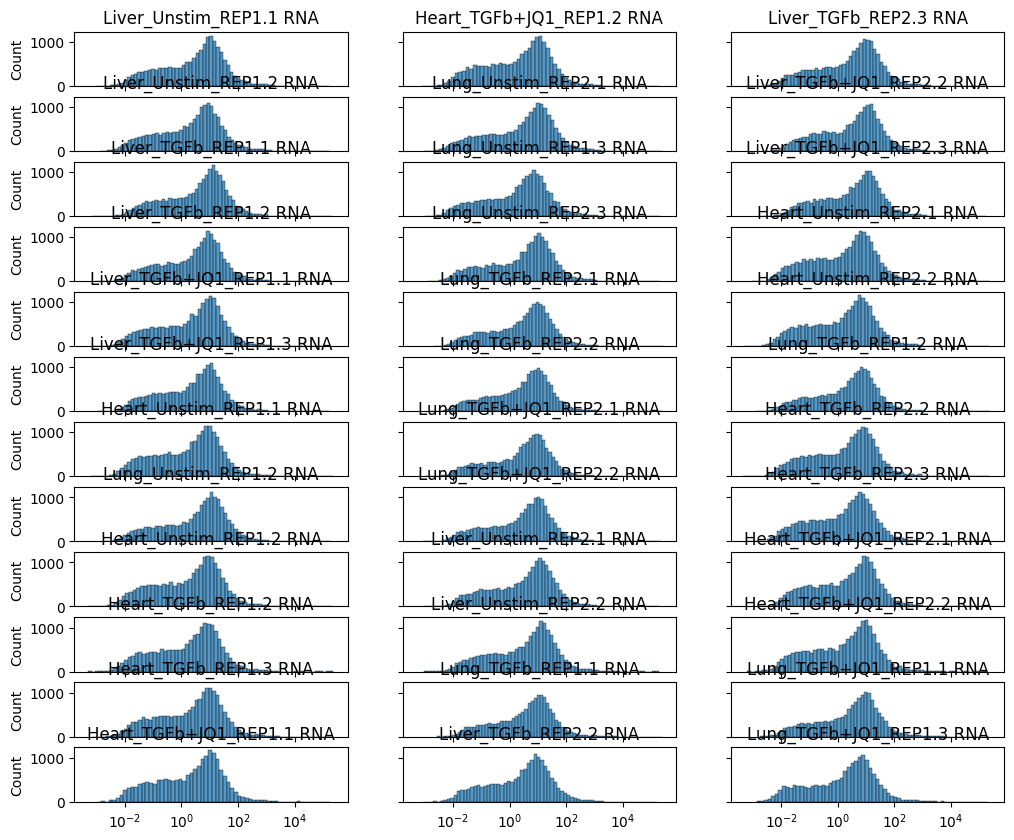

In [9]:
fig, axs = plt.subplots(12, 3, figsize=(12, 10), sharey='all', sharex='all')
for (col, ax) in zip(rna_raw_df.columns, axs.flatten(order='F')):
  sns.histplot(rna_raw_df[col], log_scale=(True, False), ax=ax)
  ax.set_xlabel('')
  ax.set_title(f'{col} RNA')

In [10]:
transcripts_per_gene = rna_adata.var['gene'].value_counts()
transcripts_per_gene = transcripts_per_gene[rna_raw_df.index]
transcripts_per_gene

gene
A1BG         1
A1BG-AS1     1
A1CF        11
A2M          2
A2M-AS1      1
            ..
ZYG11A       2
ZYG11B       2
ZYX          4
ZZEF1        7
ZZZ3         6
Name: count, Length: 29744, dtype: int64

Text(0.5, 0, 'Transcripts per Gene')

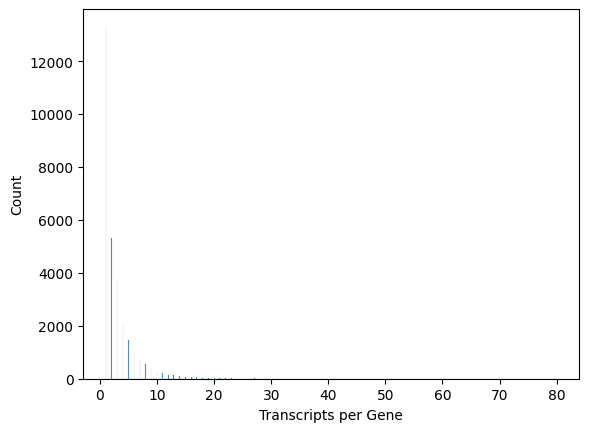

In [11]:
sns.histplot(transcripts_per_gene, log_scale=(False, False))
plt.xlabel("Transcripts per Gene")

Text(0.5, 1.0, 'Heart_Unstim_REP1.1')

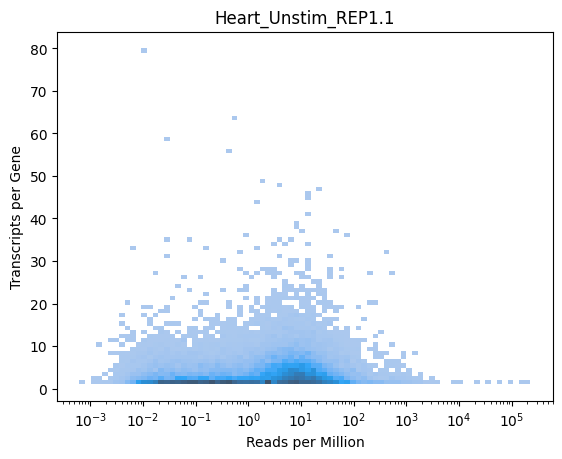

In [12]:
sns.histplot(x = rna_raw_df['Heart_Unstim_REP1.1'][rna_raw_df['Heart_Unstim_REP1.1'] > 0], y = transcripts_per_gene[rna_raw_df['Heart_Unstim_REP1.1'] > 0], log_scale=(True, False), bins=80, legend=None)
plt.xlabel("Reads per Million")
plt.ylabel("Transcripts per Gene")
plt.title('Heart_Unstim_REP1.1')

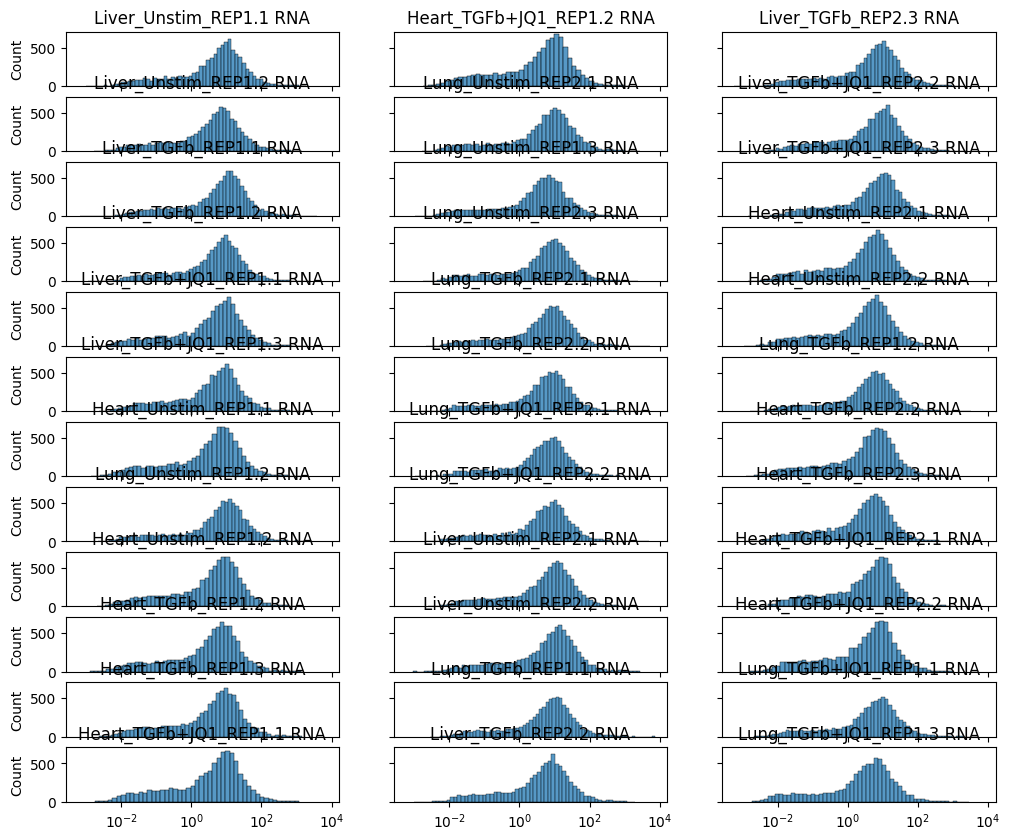

In [13]:
fig, axs = plt.subplots(12, 3, figsize=(12, 10), sharey='all', sharex='all')
for (col, ax) in zip(rna_raw_df.columns, axs.flatten(order='F')):
  sns.histplot(rna_raw_df[col][transcripts_per_gene > 2], log_scale=(True, False), ax=ax)
  ax.set_xlabel('')
  ax.set_title(f'{col} RNA')

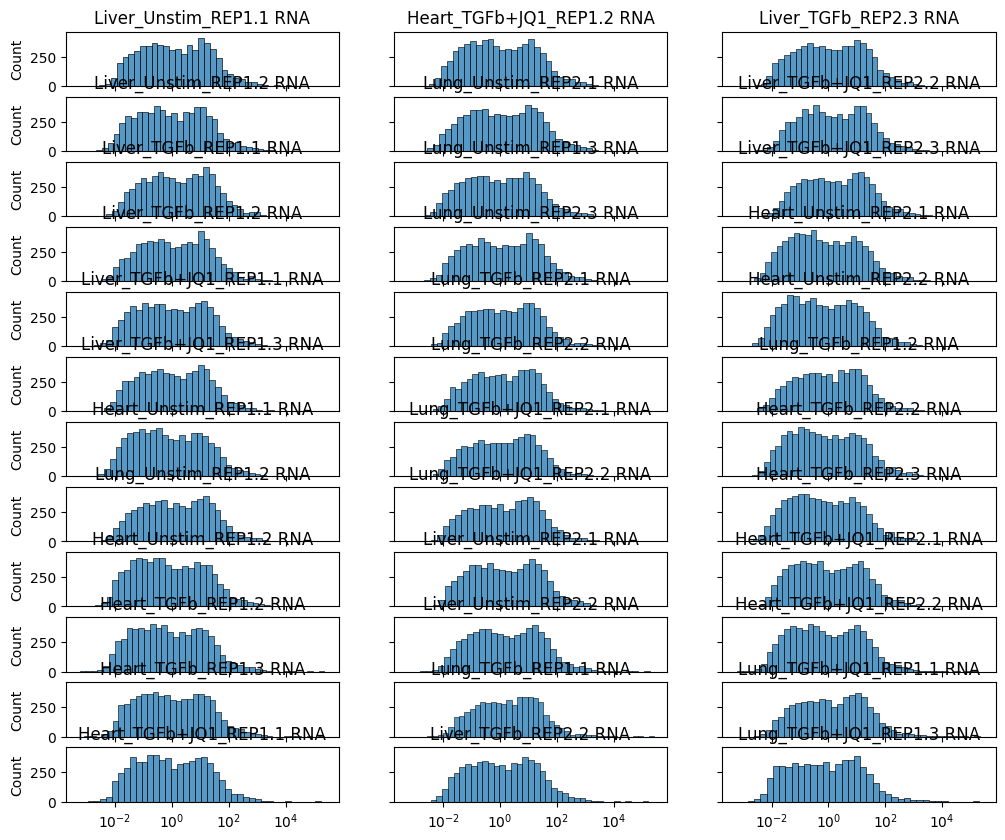

In [67]:
fig, axs = plt.subplots(12, 3, figsize=(12, 10), sharey='all', sharex='all')
for (col, ax) in zip(rna_raw_df.columns, axs.flatten(order='F')):
  sns.histplot(rna_raw_df[col][transcripts_per_gene < 2], log_scale=(True, False), ax=ax)
  ax.set_xlabel('')
  ax.set_title(f'{col} RNA')

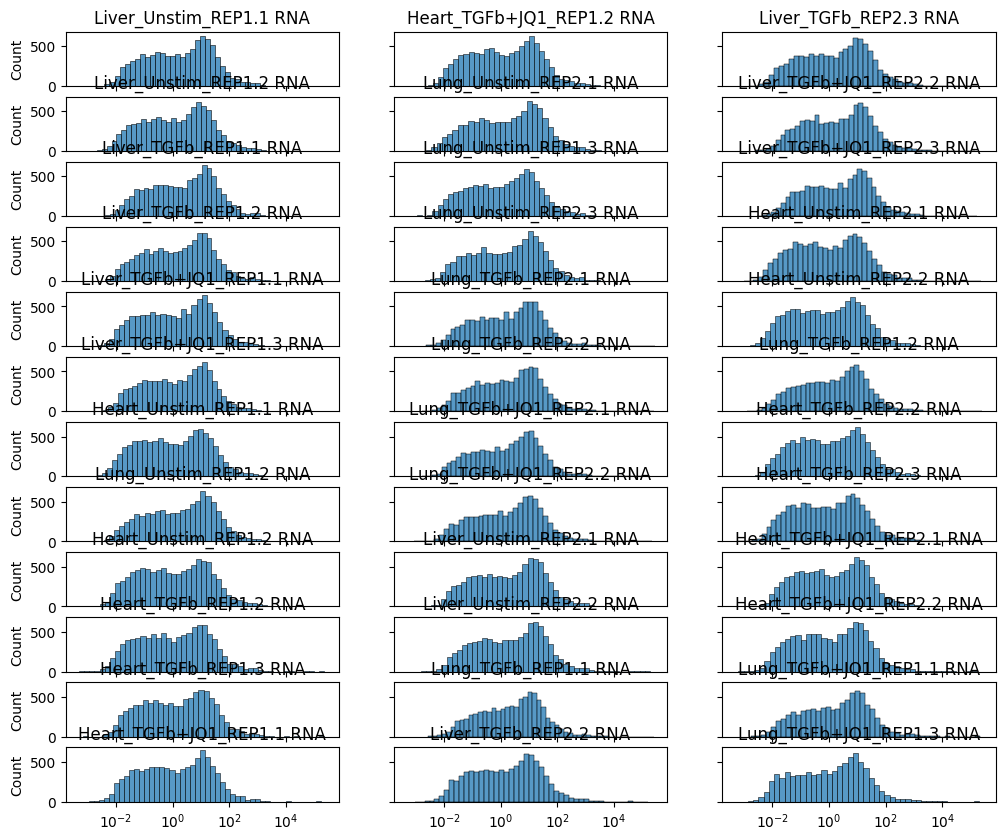

In [14]:
fig, axs = plt.subplots(12, 3, figsize=(12, 10), sharey='all', sharex='all')
for (col, ax) in zip(rna_raw_df.columns, axs.flatten(order='F')):
  sns.histplot(rna_raw_df[col][transcripts_per_gene <= 2], log_scale=(True, False), ax=ax)
  ax.set_xlabel('')
  ax.set_title(f'{col} RNA')

In [15]:
def calc_condition_gene_averages(adata: ad.AnnData, organ: str, layer: str = None) -> pd.DataFrame:
  organ_adata = adata[adata.obs['organ'] == organ, :]
  organ_df = organ_adata.to_df(layer = layer)
  organ_df['condition'] = organ_adata.obs['condition']
  condition_avg_df = organ_df.groupby('condition', observed = False).aggregate('mean').T  # Average across replicates
  condition_avg_df['gene'] = organ_adata.var['gene']
  return condition_avg_df.groupby('gene', observed = False).aggregate('sum')  # Sum across gene variants

In [16]:
organs = ['Lung', 'Heart', 'Liver']
rna_df = pd.concat([calc_condition_gene_averages(rna_adata, organ) for organ in organs], axis=1, keys=organs)

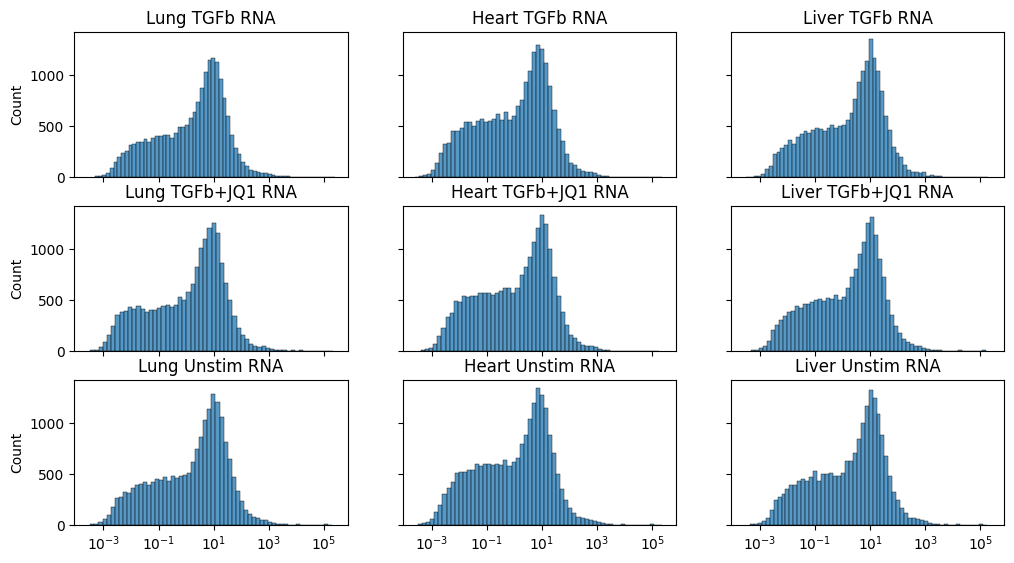

In [17]:
fig, axs = plt.subplots(3, 3, figsize=(12, 6.4), sharey='all', sharex='all')
for (col, ax) in zip(rna_df.columns, axs.flatten(order='F')):
  sns.histplot(rna_df[col], log_scale=(True, False), ax=ax)
  ax.set_xlabel('')
  ax.set_title(f'{col[0]} {col[1]} RNA')

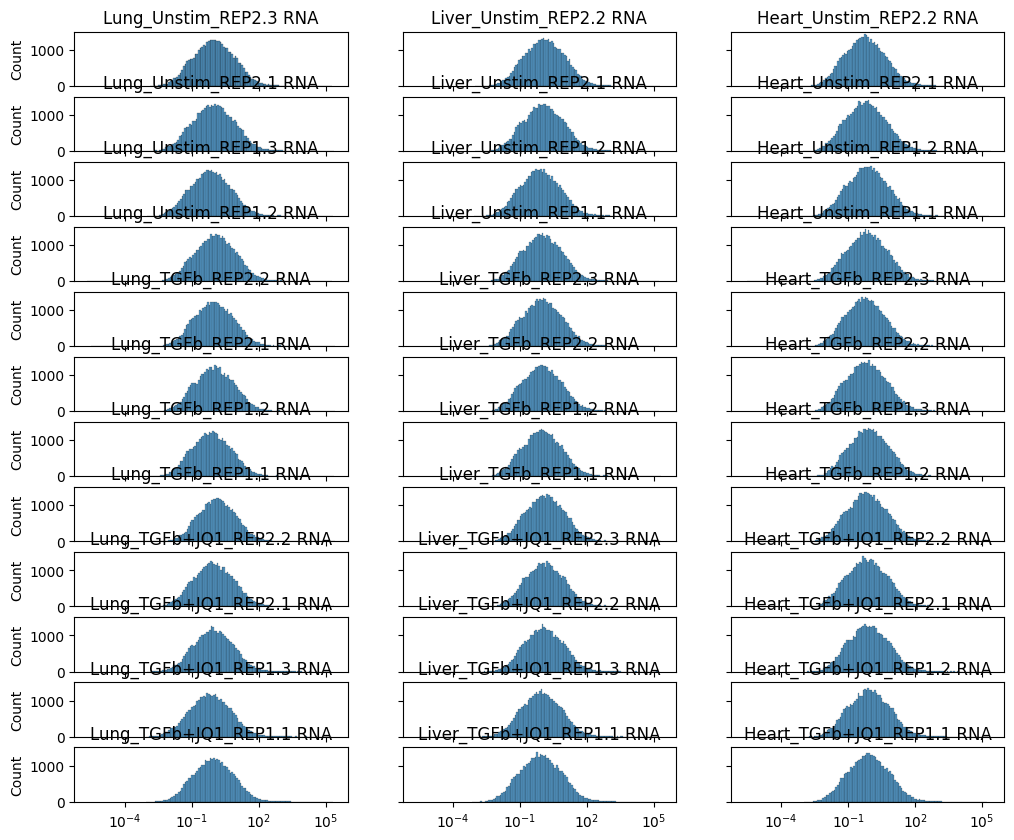

In [18]:
fig, axs = plt.subplots(12, 3, figsize=(12, 10), sharey='all', sharex='all')
for (col, ax) in zip(rna_adata.obs_names.sort_values(ascending=False), axs.flatten(order='F')):
  sns.histplot(rna_adata[col].X[0], log_scale=(True, False), ax=ax)
  ax.set_xlabel('')
  ax.set_title(f'{col} RNA')

In [19]:
def calc_condition_peak_averages(adata: ad.AnnData, organ: str, layer: str = None) -> pd.DataFrame:
  organ_adata = adata[adata.obs['organ'] == organ, :]
  organ_df = organ_adata.to_df(layer = layer)
  organ_df['condition'] = organ_adata.obs['condition']
  return organ_df.groupby('condition', observed = False).aggregate('mean').T  # Average across replicates

In [20]:
atac_df = pd.concat([calc_condition_peak_averages(atac_adata, organ) for organ in organs], axis=1, keys=organs)

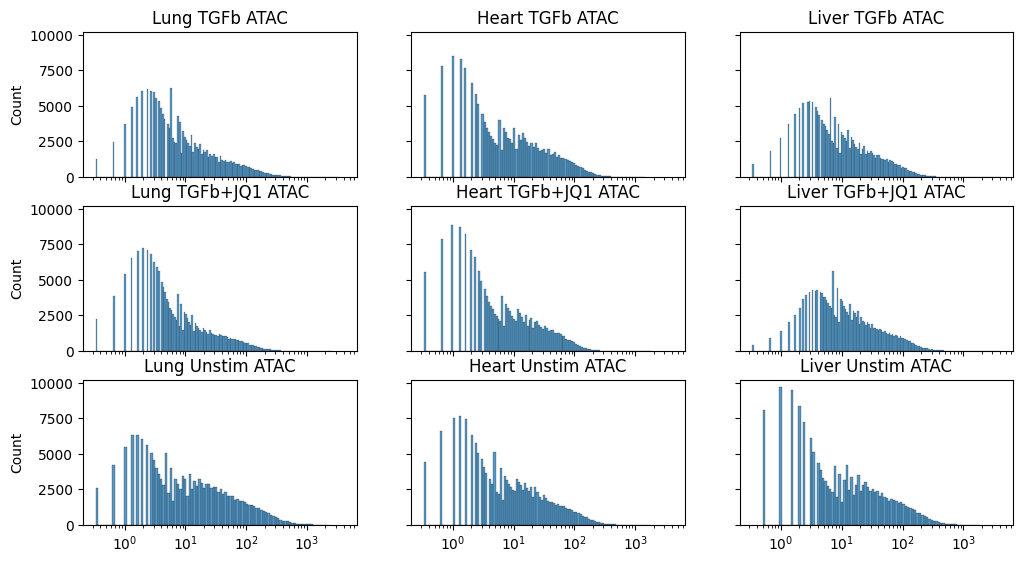

In [21]:
fig, axs = plt.subplots(3, 3, figsize=(12, 6.4), sharey='all', sharex='all')
for (col, ax) in zip(atac_df.columns, axs.flatten(order='F')):
  sns.histplot(atac_df[col], log_scale=(True, False), ax=ax)
  ax.set_xlabel('')
  ax.set_title(f'{col[0]} {col[1]} ATAC')

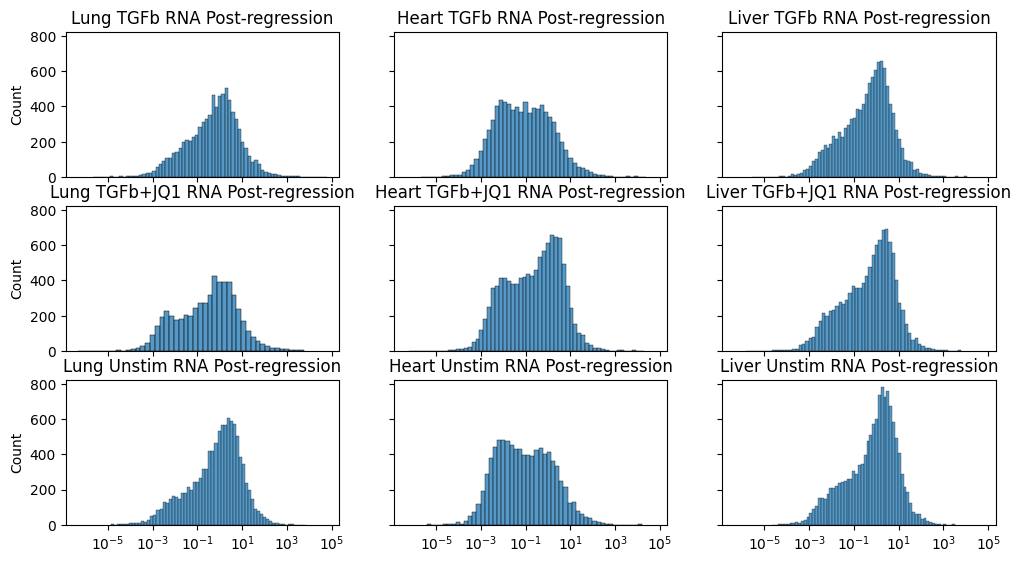

In [22]:
rna_postreg_df = pd.concat([calc_condition_gene_averages(rna_adata, organ, layer = 'post-regression') for organ in organs], axis=1, keys=organs)
fig, axs = plt.subplots(3, 3, figsize=(12, 6.4), sharey='all', sharex='all')
for (col, ax) in zip(rna_postreg_df.columns, axs.flatten(order='F')):
  sns.histplot(rna_postreg_df[col], log_scale=(True, False), ax=ax)
  ax.set_xlabel('')
  ax.set_title(f'{col[0]} {col[1]} RNA Post-regression')

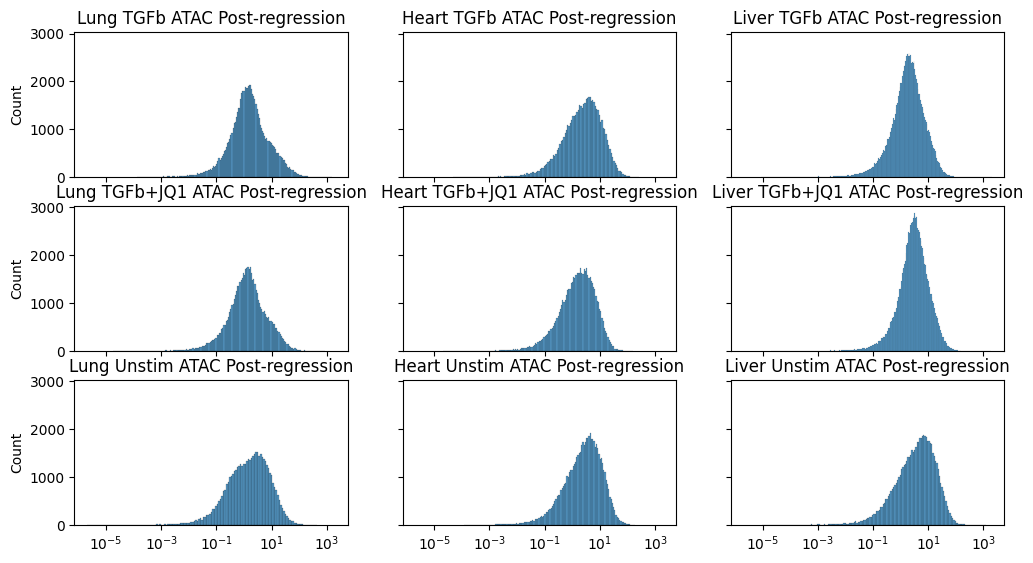

In [23]:
atac_postreg_df = pd.concat([calc_condition_peak_averages(atac_adata, organ, layer = 'post-regression') for organ in organs], axis=1, keys=organs)
fig, axs = plt.subplots(3, 3, figsize=(12, 6.4), sharey='all', sharex='all')
for (col, ax) in zip(atac_postreg_df.columns, axs.flatten(order='F')):
  sns.histplot(atac_postreg_df[col], log_scale=(True, False), ax=ax)
  ax.set_xlabel('')
  ax.set_title(f'{col[0]} {col[1]} ATAC Post-regression')

### Determine Replicability with Null Data
Create null data by randomly sampling from original data to determine if distributions would look different by random chance

In [24]:
rand = np.random.default_rng(seed=0)
random_rna_df = pd.DataFrame(rand.choice(rna_df.values.flatten(), size=rna_df.shape), columns = rna_df.columns)
random_atac_df = pd.DataFrame(rand.choice(atac_df.values.flatten(), size=atac_df.shape), columns = atac_df.columns)

In [25]:
def calc_condition_sensitivity(organ_df: pd.DataFrame) -> pd.DataFrame:
  """Uses log fold change to determine which genes are up- and down-regulated in each condition"""
  odf_copy = organ_df + 1
  lfc_df = pd.DataFrame({
    'up': np.sqrt(np.log2(odf_copy.mean(axis = 1))) * np.log2(odf_copy['TGFb'] / odf_copy['Unstim']),
    'down': np.sqrt(np.log2(odf_copy.mean(axis = 1))) * np.log2(odf_copy['TGFb+JQ1'] / odf_copy['TGFb']),
  })
  t = np.sign(np.sign(odf_copy['Unstim'] - odf_copy['TGFb']) - np.sign(odf_copy['TGFb'] - odf_copy['TGFb+JQ1']))
  lfc_df['score'] = lfc_df['up'] * lfc_df['down'] * t
  return lfc_df

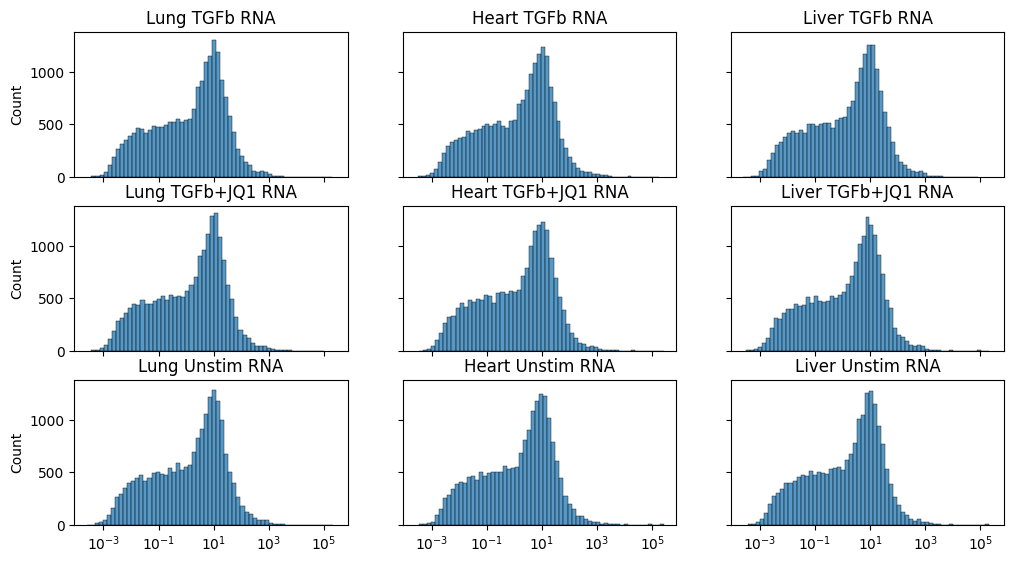

In [26]:
fig, axs = plt.subplots(3, 3, figsize=(12, 6.4), sharey='all', sharex='all')
for (col, ax) in zip(random_rna_df.columns, axs.flatten(order='F')):
  sns.histplot(random_rna_df[col], log_scale=(True, False), ax=ax)
  ax.set_xlabel('')
  ax.set_title(f'{col[0]} {col[1]} RNA')

In [27]:
random_rna_sensitivity_df = pd.concat([calc_condition_sensitivity(random_rna_df[organ])['score'] for organ in organs], axis=1, keys=organs)

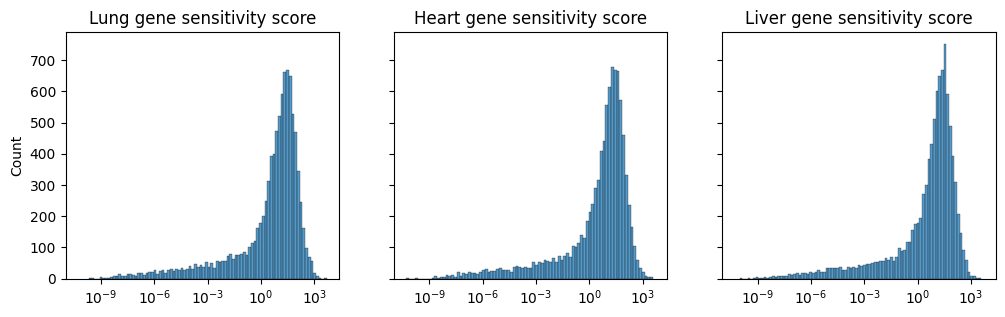

In [28]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3.2), sharey='all', sharex='all')
for (col, ax) in zip(random_rna_sensitivity_df.columns, axs.flatten(order='F')):
  sns.histplot(random_rna_sensitivity_df[col], log_scale=(True, False), ax=ax)
  ax.set_xlabel('')
  ax.set_title(f'{col} gene sensitivity score')

### Candidate Peak-Gene Enhancers

PG pairs will be sorted by their specificity and universality scores:
- High-specificity gene and high-specificity peak for same organ
- High-universality gene with different high-specificity peaks for different organs
- High-universality gene and high-universality peak

In [29]:
palette = {'Unstim': '#2ca02c', 'TGFb': '#d62728', 'TGFb+JQ1': '#1f77b4'}
markers = {'Lung': 'o', 'Heart': '^', 'Liver': 's'}

In [30]:
def get_best_pg_pairs(gene_score: pd.Series, peak_score: pd.Series, n = 10) -> list[tuple[str, str]]:
  reordered_peaks = peak_score.loc[gene_score.index]
  ordered_pairs = (gene_score * reordered_peaks * (np.sign(reordered_peaks) + np.sign(gene_score)) - 1).sort_values(ascending=False)
  top_genes = ordered_pairs.index.get_level_values(0).unique()[0:n]
  top_pairs = ordered_pairs.groupby(level=0).nth(0).loc[top_genes].index
  return top_pairs

In [31]:
def plot_pg_pairs(gene_score: pd.Series, peak_score: pd.Series, best_peaks: list[tuple[str, str]] = [], **kwargs) -> plt.Axes: 
  plot_args = {
    **kwargs
  }
  if len(best_peaks) > 0:
    plot_args['hue'] = gene_score.index.isin(best_peaks)
  ax = sns.scatterplot(x = gene_score, y = peak_score.loc[gene_score.index], legend = None, **plot_args)
  for (gene, peak) in best_peaks:
    point = gene_score.loc[(gene, peak)], peak_score.loc[(gene, peak)]
    ax.text(point[0], point[1], f'{gene}-{peak}', size='x-small', va='bottom')
  return ax

In [32]:
organ_to_best_specificity_pairs = {
  organ: get_best_pg_pairs(specificity_df[organ, 'gene_score'], specificity_df[organ, 'peak_score']) for organ in markers.keys()
}

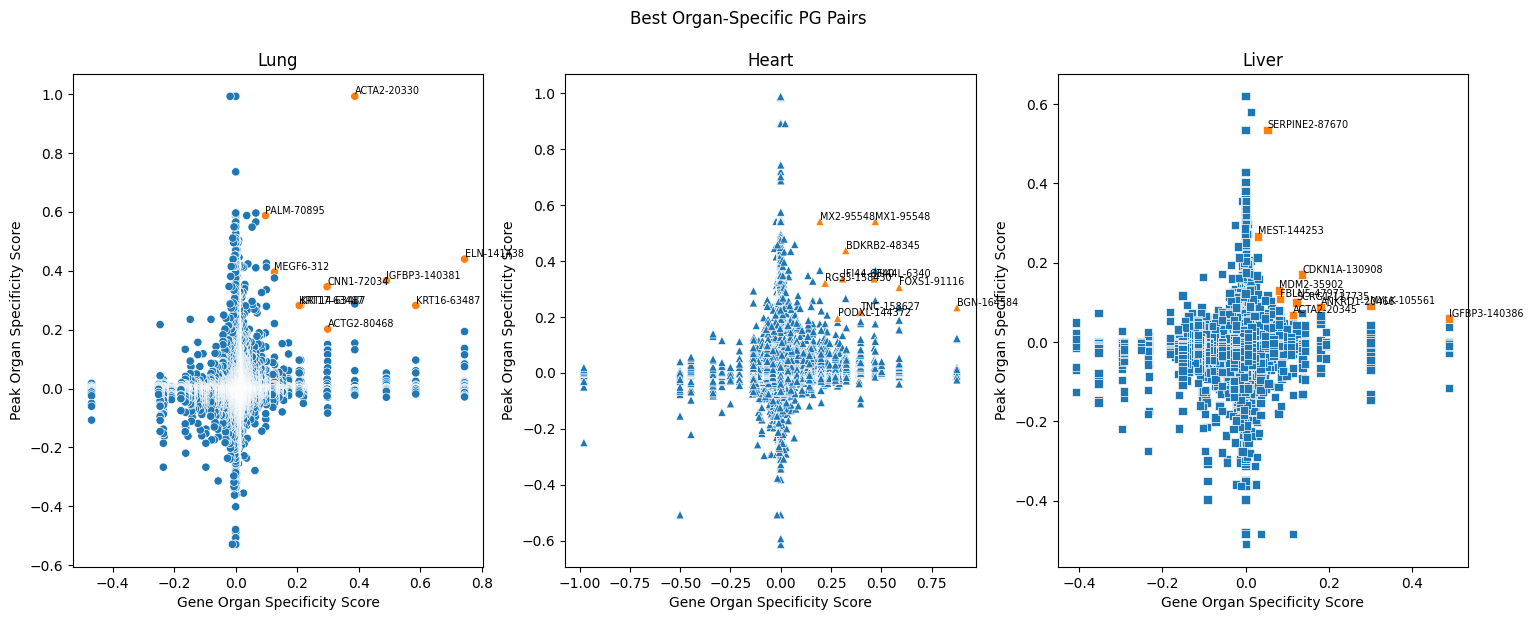

In [33]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6.4))
for (ax, organ) in zip(axs, markers.keys()):
  plot_pg_pairs(specificity_df[organ, 'gene_score'], specificity_df[organ, 'peak_score'], organ_to_best_specificity_pairs[organ], ax=ax, marker=markers[organ])
  ax.set_title(organ)
  ax.set_xlabel('Gene Organ Specificity Score')
  ax.set_ylabel('Peak Organ Specificity Score')
fig.suptitle("Best Organ-Specific PG Pairs")
plt.show()

In [34]:
organ_to_universal_gene_specific_peaks = {
  organ: get_best_pg_pairs(universality_df['gene_score'], specificity_df[organ, 'peak_score']) for organ in markers.keys()
}

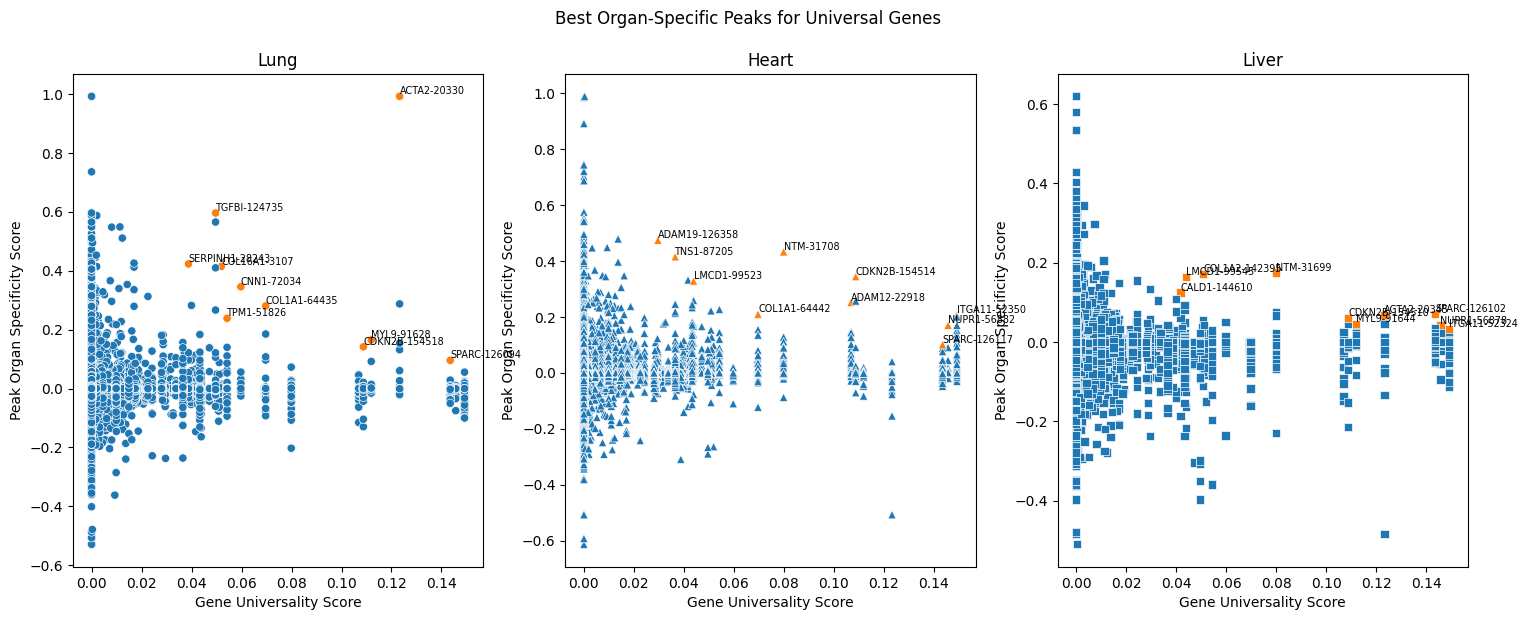

In [35]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6.4))
for (ax, organ) in zip(axs, markers.keys()):
  plot_pg_pairs(universality_df['gene_score'], specificity_df[organ, 'peak_score'], organ_to_universal_gene_specific_peaks[organ], ax=ax, marker=markers[organ])
  ax.set_title(organ)
  ax.set_xlabel('Gene Universality Score')
  ax.set_ylabel('Peak Organ Specificity Score')
fig.suptitle("Best Organ-Specific Peaks for Universal Genes")
plt.show()

In [36]:
universal_pg_pairs = get_best_pg_pairs(universality_df['gene_score'], universality_df['peak_score'])

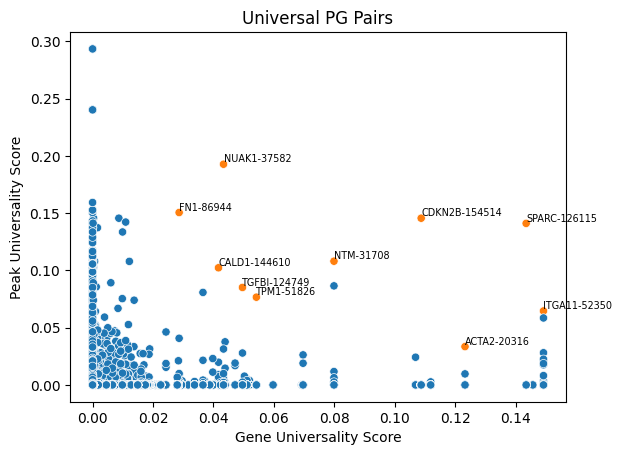

In [37]:
ax = plot_pg_pairs(universality_df['gene_score'], universality_df['peak_score'], universal_pg_pairs)
ax.set_title('Universal PG Pairs')
ax.set_xlabel('Gene Universality Score')
ax.set_ylabel('Peak Universality Score')
plt.show()

In [64]:
def plot_expression(adata: ad.AnnData, gene: str, layer: str = None, points = False, **kwargs) -> plt.Axes:
  gene_rna_adata = adata[:, adata.var['gene'] == gene]
  ax = sns.boxplot(gene_rna_adata.obs, x = 'organ', y = gene_rna_adata.to_df(layer = layer).sum(axis = 1), order=markers.keys(), hue = 'condition', palette=palette, hue_order = palette.keys(), fliersize = 0 if points else None, **kwargs)
  if 'ax' not in kwargs:
    kwargs['ax'] = ax
  if points:
    sns.stripplot(gene_rna_adata.obs, x = 'organ', y = gene_rna_adata.to_df(layer = None).sum(axis = 1), order=markers.keys(), hue = 'condition', palette=palette, edgecolor='black', linewidth=1, hue_order = palette.keys(), dodge=True, **kwargs)
  ax.set_ylabel(f'{gene} expression {layer if layer is not None else ""}')
  return ax

def plot_peak(adata: ad.AnnData, peak: str, layer: str = None, points = False, **kwargs) -> plt.Axes:
  ax = sns.boxplot(adata.obs, x = 'organ', y = adata[:, peak].to_df(layer = layer).sum(axis = 1), order=markers.keys(), hue = 'condition', palette=palette, hue_order = palette.keys(), fliersize = 0 if points else None, **kwargs)
  if 'ax' not in kwargs:
    kwargs['ax'] = ax
  if points:
    sns.stripplot(adata.obs, x = 'organ', y = adata[:, peak].to_df(layer = None).sum(axis = 1), order=markers.keys(), hue = 'condition', palette=palette, edgecolor='black', linewidth=1, hue_order = palette.keys(), dodge=True, **kwargs)
  ax.set_ylabel(f'{peak} peaks {layer if layer is not None else ""}')
  return ax

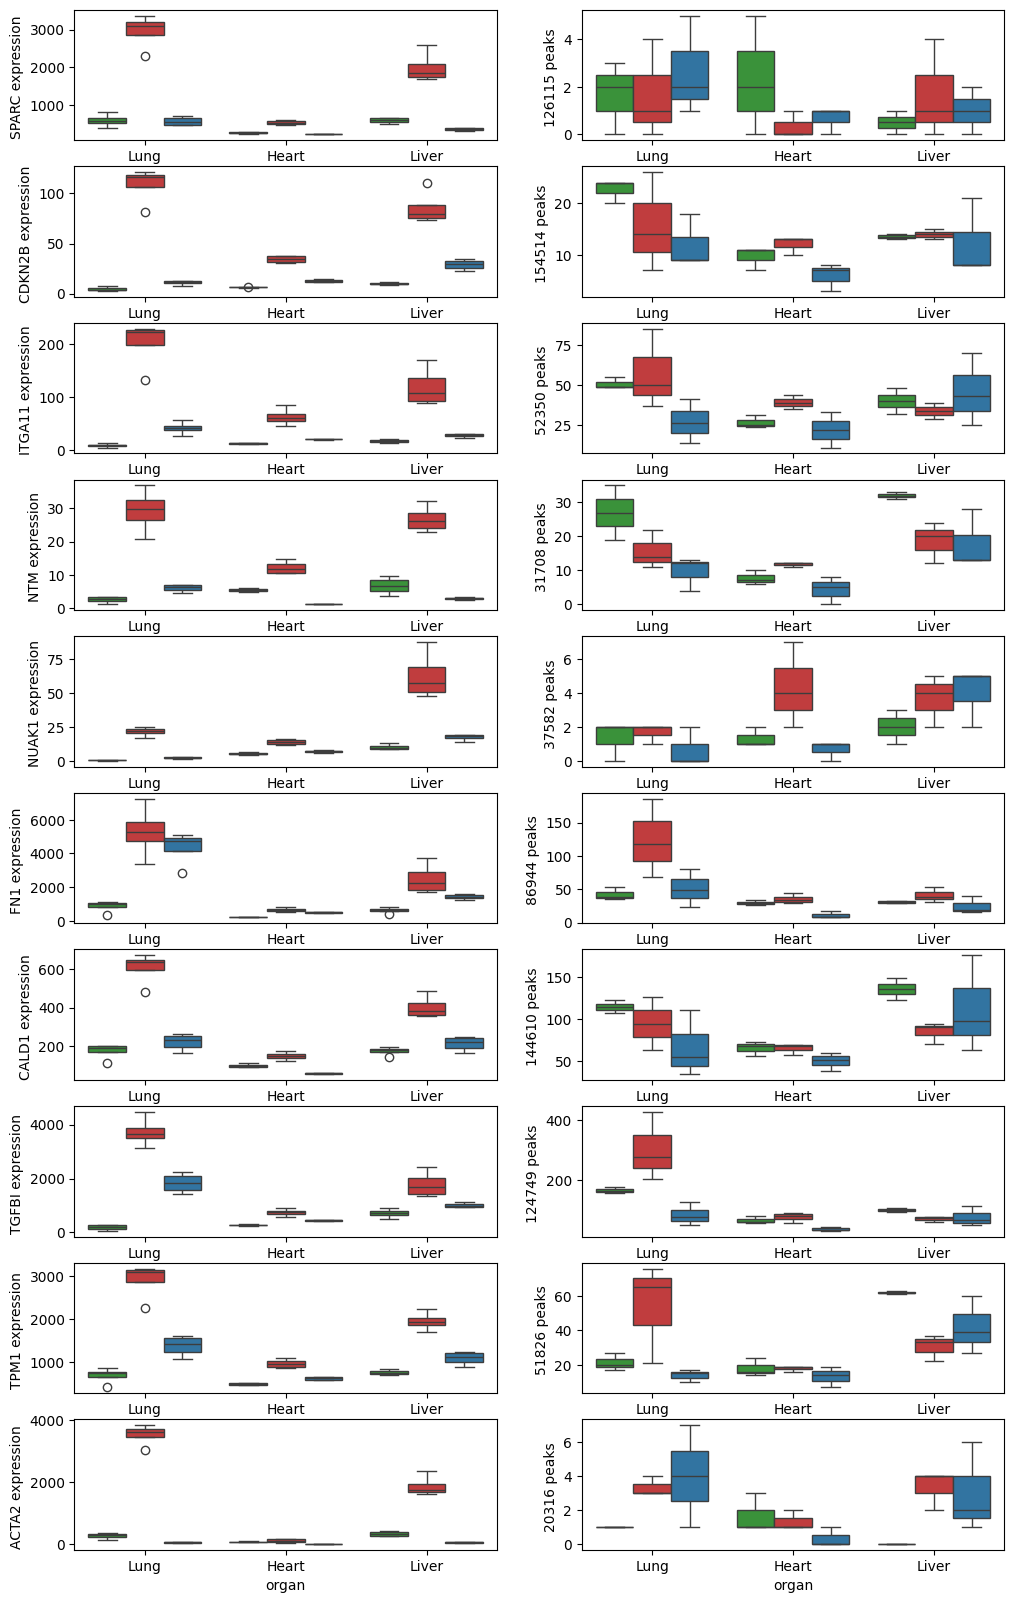

In [65]:
fig, rows = plt.subplots(10, 2, figsize=(12, 20))
for (gene, peak), (ax1, ax2) in zip(universal_pg_pairs, rows):
  plot_expression(rna_adata, gene, ax=ax1, legend = None)
  plot_peak(atac_adata, peak, ax=ax2, legend = None)

In [40]:
candidate_dict = {}
candidate_dict.update({('organ-specific peak-gene', organ): pairs for organ, pairs in organ_to_best_specificity_pairs.items()})
candidate_dict.update({('organ-specific peak', organ): pairs for organ, pairs in organ_to_universal_gene_specific_peaks.items()})
candidate_dict.update({('universal peak-gene', ''): universal_pg_pairs})
candidate_df = pd.DataFrame(candidate_dict)
candidate_df.to_csv('./data/candidate_pg_pairs.csv')
candidate_df

organ-specific peak-gene                                      \
                      Lung            Heart              Liver   
0           (ACTA2, 20330)     (MX1, 95548)   (IGFBP3, 140386)   
1            (ELN, 141438)    (BGN, 164584)  (SERPINE2, 87670)   
2         (IGFBP3, 140381)   (FOXS1, 91116)     (MYLK, 105561)   
3           (KRT16, 63487)   (IFI44L, 6340)   (CDKN1A, 130908)   
4            (CNN1, 72034)  (BDKRB2, 48345)    (ANKRD1, 20466)   
5           (ACTG2, 80468)     (MX2, 95548)    (SCRG1, 117735)   
6           (KRT14, 63487)    (IFI44, 6340)      (MDM2, 35902)   
7           (KRT17, 63487)    (TNC, 158627)     (FBLN5, 47973)   
8            (PALM, 70895)   (RGS3, 158430)     (MEST, 144253)   
9             (MEGF6, 312)  (PODXL, 144372)     (ACTA2, 20345)   

  organ-specific peak                                     universal peak-gene  
                 Lung             Heart             Liver                      
0      (ACTA2, 20330)  (CDKN2B, 154514)      (NTM, 31699)     (SPARC, 126115)  
1     (TGFBI, 124735)      (NTM, 31708)   (SPARC, 126102)    (CDKN2B, 154514)  
2     (COL16A1, 3107)   (ITGA11, 52350)  (COL1A2, 142395)     (ITGA11, 52350)  
3       (CNN1, 72034)   (ADAM12, 22918)    (ACTA2, 20345)        (NTM, 31708)  
4     (COL1A1, 64435)    (NUPR1, 56882)    (LMCD1, 99545)      (NUAK1, 37582)  
5       (MYL9, 91628)     (TNS1, 87205)  (CDKN2B, 154510)        (FN1, 86944)  
6   (SERPINH1, 28243)   (COL1A1, 64442)    (NUPR1, 56878)     (CALD1, 144610)  
7    (CDKN2B, 154518)   (SPARC, 126117)   (CALD1, 144610)     (TGFBI, 124749)  
8     (SPARC, 126094)    (LMCD1, 99523)     (MYL9, 91644)       (TPM1, 51826)  
9       (TPM1, 51826)  (ADAM19, 126358)   (ITGA11, 52324)      (ACTA2, 20316)

<Axes: xlabel='organ', ylabel='20316 peaks '>

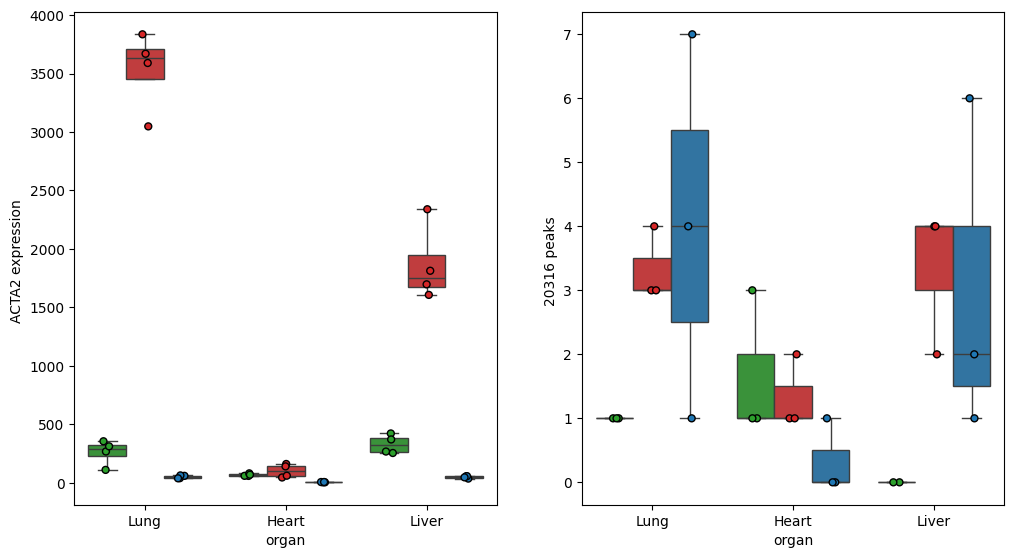

In [66]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12, 6.4))
plot_expression(rna_adata, 'ACTA2', points=True, ax=ax1, legend = None)
plot_peak(atac_adata, 20316, points=True, ax=ax2, legend = None)